In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
import OldDecodingTools as odt
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
import h5py
from ipyparallel import Client
#import tables as tb
from copy import deepcopy
#from KDEpy import FFTKDE

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)

act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

%run animal_info
ANIMAL = 'AC_12102016'

In [2]:
TRIAL_DURATION = 10
PRE_TRIAL_DURATION = 2.5

def extract_spikes(hd5_file, neuron_num=0):
    """Extracts the spiking data from the hdf5 file. Returns an array of
    spike times.

    Keyword arguments:
    neuron_num -- the index of the neuron you would like to access.
    """
    with h5py.File(hd5_file, "r+") as f:
        neuron_list = f['NF']['value']['neurons']['value']
        if len(neuron_list) <= 10:
            neuron_str = "_" + str(neuron_num)
        else:
            neuron_str = "_" + "0" * (2 - len(str(neuron_num))) + str(neuron_num)
        timestamps = numpy.array(neuron_list[neuron_str]['value']['timestamps']['value'][0])
    return(timestamps)


def extract_events(hd5_file):
    """Extracts the timestamps of the events stored in the hdf5 file."""
    events = {}
    with h5py.File(hd5_file, "r+") as f:
        event_list = f['NF']['value']['events']['value']
        for key in event_list.keys():
            if key == 'dims':
                continue
            name = event_list[key]['value']['name']['value']
            # The hdf5 that results file contains the names not as strings
            # but as an array of integers which code for the string in
            # ASCII format.
            #name_str = ''.join(map(chr, name))
            name_str = ''.join([chr(c[0]) for c in numpy.array(name)])
            try:
                timestamps = numpy.array(event_list[key]['value']['timestamps']['value'][0])
            except:
                timestamps = numpy.array([], dtype='float64')
            events[name_str] = timestamps
    return(events)


def load_events_spikes_script(neuron_num=0, base_dir='C:\\Users\\insan\\Desktop\\elife\\code', spike_files=None, event_files=None, exception=None, variables=None, **kwargs):
    """Extracts spikes and events
    """
    event_set = [extract_events(os.path.join(base_dir, f)) for f in event_files]
    if type(neuron_num) is int:
        if exception is not None:
            spike_set = [event_set[i][exception[neuron_num]] for i in range(len(event_set))]
        else:
            spike_set = [extract_spikes(os.path.join(base_dir, f), neuron_num) for f in spike_files]
    elif (type(neuron_num) is list) or (type(neuron_num) is tuple):
        spike_set = []
        for num in neuron_num:
            if exception is not None:
                spike_set_temp = [event_set[i][exception[num]] for i in range(len(event_set))]
            else:
                spike_set_temp = [extract_spikes(os.path.join(base_dir, f), num) for f in spike_files]
            spike_set.append(spike_set_temp)
    return(event_set, spike_set)


######################
# Basic Calculations #
######################


def create_complete_table(event_set, spike_set, variable_maps, pre_trial_duration=PRE_TRIAL_DURATION, trial_duration=TRIAL_DURATION, stim_variables=['T', 'F'], action_variables=['NPT', 'NPF']):
    assert len(action_variables) == len(stim_variables)
    stimuli = []
    stimuli_time = []
    actions = []
    correctness = []
    nose_pokes = []
    num_neurons = len(spike_set)
    responses = [[] for i in range(num_neurons)]
    all_trial_times = []
    for events, spikes_list, variable_map in zip(event_set, zip(*spike_set), variable_maps):
        for stim_variable, action_variable in zip(stim_variables, action_variables):
            trial_times = events[variable_map[stim_variable]]
            try:
                nose_poke_times = numpy.array(events[variable_map[action_variable]])
            except:
                nose_poke_times = None
            try:
                correct_times = events[variable_map[stim_variable + '+']]
            except:
                correct_times = None

            all_trial_times.extend(trial_times)

            for i, trial_time in enumerate(trial_times):
                stimuli.append(stim_variable)
                stimuli_time.append(trial_time)

                # finding correctness of trial
                if correct_times is None:
                    correctness.append('U')
                elif trial_time in correct_times:
                    correctness.append('+')
                else:
                    correctness.append('-')

                # finding nosepoke time
                if nose_poke_times is None:
                    nose_pokes.append(numpy.nan)  # This conflates no response with unkown response.  There is probably a better system
                    actions.append('U')
                else:
                    if i == len(trial_times) - 1:
                        index = (nose_poke_times > trial_time)
                    else:
                        index = (nose_poke_times > trial_time)*(nose_poke_times < trial_times[i+1])
                    if sum(index) == 0:
                        nose_poke_time = numpy.nan
                        actions.append('W')
                    else:
                        nose_poke_time = nose_poke_times[index][0] - trial_time
                        actions.append('NP')
                    nose_pokes.append(nose_poke_time)

                for i, spikes in enumerate(spikes_list):
                    current_response = spikes[(spikes >= trial_time - pre_trial_duration)*(spikes < (trial_time + trial_duration))] - trial_time
                    responses[i].append(deepcopy(current_response))

    sort_index = numpy.argsort(all_trial_times)
    for i, response in enumerate(responses):
        responses[i] = numpy.array(response)[sort_index]

    return(numpy.array(stimuli_time)[sort_index], numpy.array(stimuli)[sort_index], numpy.array(actions)[sort_index], numpy.array(nose_pokes)[sort_index], responses)

def load_session_h5py(ANIMAL):
    animal_info = ANIMALS[ANIMAL]
    neuron = 0
    trial_duration = animal_info['trial_duration']
    last_trial = animal_info['last_trial']

    event_set, spike_set = load_events_spikes_script(neuron_num=neuron, **animal_info)
    st0, s0, a0, np0, r0 = create_complete_table(event_set, spike_set, animal_info['variables'], 
                                                        trial_duration = trial_duration, 
                                                        pre_trial_duration = trial_duration)

    #Meta
    sessionfile = SimpleNamespace()
    sessionfile.meta = SimpleNamespace()
    sessionfile.meta.fs = 30000
    sessionfile.meta.length_in_trials = len(s0)
    sessionfile.meta.task = 'nonreversal'#

    #Trials
    sessionfile.trials = SimpleNamespace()
    sessionfile.trials.target = s0 == 'T'
    sessionfile.trials.go = a0 == 'NP'
    sessionfile.trials.starts = st0
    sessionfile.trials.ends = sessionfile.trials.starts + trial_duration
    sessionfile.trials.starts *= sessionfile.meta.fs
    sessionfile.trials.ends *= sessionfile.meta.fs

    #Clusters
    sessionfile.clusters = SimpleNamespace()
    sessionfile.clusters.good = animal_info['all_neurons']

    #Spikes
    sessionfile.spikes = SimpleNamespace()
    sessionfile.spikes.times = []
    sessionfile.spikes.clusters = []
    for clust in sessionfile.clusters.good:
        _, spike_set_clust = load_events_spikes_script(neuron_num=[clust], **animal_info)
        spikes = spike_set_clust[0][0]
        spikes *= sessionfile.meta.fs
        clusters = np.full_like(spikes,clust)    
        sessionfile.spikes.times = np.concatenate((sessionfile.spikes.times,spikes))
        sessionfile.spikes.clusters = np.concatenate((sessionfile.spikes.clusters,clusters))

    #Trim
    sessionfile.trim = dict()
    for clust in sessionfile.clusters.good:
        sessionfile.trim[clust] = SimpleNamespace()
        sessionfile.trim[clust].trimmed_trials = list(range(len(s0)))
        
    return sessionfile

# Run Calculations on Mouse Data

Activate Engines

In [2]:
#rc = Client('/Users/balbanna/.starcluster/ipcluster/SecurityGroup:@sc-MI-us-east-1.json', sshkey='/Users/badr/.ssh/EC2key.rsa')
rc = Client()
dv = rc[:]
dv.block = True
dv.activate()
print("Number of active engines: {0}".format(len(dv)))

Number of active engines: 16


In [3]:
%%px --block
import sys, os
import numpy as np
import InsanallyLabEphysTools as ilep
import pickle

act_directory = 'D:\\Analysis_Cache'
categories = 'response'
reps = 1000

#%load_ext autoreload
#%autoreload 2
#%run animal_info

In [4]:
act_directory = 'D:\\Analysis_Cache'
#categories = 'stimulus'
categories = 'response'
reps = 1000

Run Calculation

In [6]:
def calculateDecodingForSingleNeuron(session,clust,directory):
    print(directory)
    print(session)
    sessionfile = ilep.loadSessionCached(directory,session)
    filename = ilep.generateDateString(sessionfile) + ' cluster ' + str(clust) + ' decoding cached result.pickle'
    filename = os.path.join('D:\\Temp_Cache',filename)
    
    if os.path.isfile(filename):
        return [np.nan]*15
        #with open(filename, 'rb') as f:
        #    res = pickle.load(f)
        #    return res
    else:
        try:    
            #a,astd,asem,wa,wastd,wasem,ca,castd,casem,pval = ilep.cachedCalculateClusterAccuracy(sessionfile,clust,reps=reps,categories='stimulus')
            res = ilep.cachedCalculateClusterAccuracy(sessionfile,clust,reps=reps,categories=categories)
        except Exception as e:
            #raise e
            print(e)
            res = [np.nan]*15
        with open(filename, 'wb') as f:
            pickle.dump(res, f, protocol=pickle.HIGHEST_PROTOCOL)
            
    return res

# Dual Recording

In [ ]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in sessions:
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #if sessionfile.meta.animal = 'BS_50':
    #    continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)
        
#EnumSession = EnumSession[0:24]
#EnumClust = EnumClust[0:24]

#res = calculateDecodingForSingleNeuron(EnumSession[0],EnumClust[0])
#print(res)

#Parallel Execution
start_time = datetime.now()
print('Starting run at: '+str(start_time))
res = dv.map_sync(calculateDecodingForSingleNeuron, EnumSession,EnumClust,[act_directory]*len(EnumClust))
#res = calculateDecodingForSingleNeuron(EnumSession[0],EnumClust[0],act_directory)
#print(res)

end_time = datetime.now()
print('Elapsed time: '+str(end_time-start_time))
        
finish_time = datetime.now()
print('Run completed at '+str(finish_time))

Starting run at: 2023-01-06 13:31:09.409195


# Recreate from cached results

In [13]:
sessionIDs = []
clusters = []
accuracies = []
accuracies_std = []
accuracies_sem = []
waccuracies = []
waccuracies_std = []
waccuracies_sem = []
caccuracies = []
caccuracies_std = []
caccuracies_sem = []
saccuracies = []
saccuracies_std = []
saccuracies_sem = []
pvals_c = []
pvals_s = []
frac_empty = []
repetitions = []

EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in sessions:
    sessionfile = ilep.loadSessionCached(act_directory,session)
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)
        
#EnumSession = EnumSession[0:24]
#EnumClust = EnumClust[0:24]
        
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    filename = ilep.generateDateString(sessionfile) + ' cluster ' + str(clust) + ' decoding cached result.pickle'
    filename = os.path.join('D:\\Temp_Cache',filename)
    
    this_res = [np.nan]*15
    try:
        with open(filename, 'rb') as f:
            this_res = pickle.load(f)
    except Exception as e:
        #print(filename + ' failed')
        #print(e)
        pass
    
    try:
        accuracies.append(this_res[0])
        accuracies_std.append(this_res[1])
        accuracies_sem.append(this_res[2])

        waccuracies.append(this_res[3])
        waccuracies_std.append(this_res[4])
        waccuracies_sem.append(this_res[5])

        caccuracies.append(this_res[6])
        caccuracies_std.append(this_res[7])
        caccuracies_sem.append(this_res[8])

        saccuracies.append(this_res[9])
        saccuracies_std.append(this_res[10])
        saccuracies_sem.append(this_res[11])

        pvals_c.append(this_res[12])
        pvals_s.append(this_res[13])

        frac_empty.append(this_res[14])
    except:
        print(filename)
    
    sessionIDs.append(EnumSession[idx])
    clusters.append(EnumClust[idx])
    repetitions.append(reps)
    
############################################ SAVE #######################################################
    
data = np.column_stack([sessionIDs,clusters,accuracies,accuracies_std,accuracies_sem,waccuracies,waccuracies_std,waccuracies_sem,caccuracies,caccuracies_std,caccuracies_sem,saccuracies,saccuracies_std,saccuracies_sem,pvals_c,pvals_s,frac_empty,repetitions])
labels = ['sessions','clusters','accuracies','accuracies_std','accuracies_sem','waccuracies','waccuracies_std','waccuracies_sem','caccuracies','caccuracies_std','caccuracies_sem','saccuracies','saccuracies_std','saccuracies_sem','pvals_c','pvals_s','frac_empty','repetitions']
df = pd.DataFrame(data=data, columns=labels)

filename = 'D:\\MouseData'+categories+'DecodingCached'+str(len(clusters))+'units'+str(datetime.now())
filename = filename.split(' ')[0]
filename = filename + 'FromCache.csv'
df.to_csv(filename)

save_time = datetime.now()
print('Data saved to '+filename+' at: '+str(save_time))

5801it [00:25, 228.70it/s]


Data saved to D:\MouseDatachoiceDecodingCached5801units2022-12-20FromCache.csv at: 2022-12-20 15:51:48.575558


# Opsin Recording

In [ ]:
EnumSession = []
EnumClust = []
sessions = os.listdir(ops_directory)
for session in sessions:
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)
        
EnumSession = EnumSession[0:24]
EnumClust = EnumClust[0:24]

#res = calculateDecodingForSingleNeuron(EnumSession[0],EnumClust[0])
#print(res)

#Parallel Execution
start_time = datetime.now()
print('Starting run at: '+str(start_time))
res = dv.map_sync(calculateDecodingForSingleNeuron, EnumSession,EnumClust,[ops_directory]*len(EnumClust))
end_time = datetime.now()
print('Elapsed time: '+str(end_time-start_time))
        
finish_time = datetime.now()
print('Run completed at '+str(finish_time))

Starting run at: 2022-12-06 10:52:19.829142


# Recreate from cached results

In [12]:
sessionIDs = []
clusters = []
accuracies = []
accuracies_std = []
accuracies_sem = []
waccuracies = []
waccuracies_std = []
waccuracies_sem = []
caccuracies = []
caccuracies_std = []
caccuracies_sem = []
saccuracies = []
saccuracies_std = []
saccuracies_sem = []
pvals_c = []
pvals_s = []
frac_empty = []
repetitions = []

EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in sessions:
    sessionfile = ilep.loadSessionCached(act_directory,session)
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)
        
#EnumSession = EnumSession[0:24]
#EnumClust = EnumClust[0:24]
        
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    filename = ilep.generateDateString(sessionfile) + ' cluster ' + str(clust) + ' decoding cached result.pickle'
    filename = os.path.join('D:\\Temp_Cache',filename)
    
    this_res = [np.nan]*10
    try:
        with open(filename, 'rb') as f:
            this_res = pickle.load(f)
    except Exception as e:
        #print(filename + ' failed')
        #print(e)
        pass
    
    accuracies.append(this_res[0])
    accuracies_std.append(this_res[1])
    accuracies_sem.append(this_res[2])
            
    waccuracies.append(this_res[3])
    waccuracies_std.append(this_res[4])
    waccuracies_sem.append(this_res[5])
            
    caccuracies.append(this_res[6])
    caccuracies_std.append(this_res[7])
    caccuracies_sem.append(this_res[8])
    
    saccuracies.append(this_res[9])
    saccuracies_std.append(this_res[10])
    saccuracies_sem.append(this_res[11])
    
    pvals_c.append(this_res[12])
    pvals_s.append(this_res[13])
    
    frac_empty.append(this_res[14])
            
    sessionIDs.append(EnumSession[idx])
    clusters.append(EnumClust[idx])
    repetitions.append(reps)
    
############################################ SAVE #######################################################
    
data = np.column_stack([sessionIDs,clusters,accuracies,accuracies_std,accuracies_sem,waccuracies,waccuracies_std,waccuracies_sem,caccuracies,caccuracies_std,caccuracies_sem,saccuracies,saccuracies_std,saccuracies_sem,pvals_c,pvals_s,frac_empty,repetitions])
labels = ['sessions','clusters','accuracies','accuracies_std','accuracies_sem','waccuracies','waccuracies_std','waccuracies_sem','caccuracies','caccuracies_std','caccuracies_sem','saccuracies','saccuracies_std','saccuracies_sem','pvals_c','pvals_s','frac_empty','repetitions']
df = pd.DataFrame(data=data, columns=labels)

filename = 'D:\\MouseData'+categories+'DecodingCached'+str(len(clusters))+'units'+str(datetime.now())
filename = filename.split(' ')[0]
filename = filename + 'FromCache.csv'
df.to_csv(filename)

save_time = datetime.now()
print('Data saved to '+filename+' at: '+str(save_time))

111it [00:00, 143.69it/s]


IndexError: list index out of range

In [ ]:
start_time = datetime.now()
print('Starting run at: '+str(start_time))

sessionIDs = []
clusters = []
accuracies = []
accuracies_std = []
accuracies_sem = []
waccuracies = []
waccuracies_std = []
waccuracies_sem = []
caccuracies = []
caccuracies_std = []
caccuracies_sem = []
pvals = []
repetitions = []

EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in sessions:
    sessionfile = ilep.loadSessionCached(act_directory,session)
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

for idx in tqdm(range(len(EnumClust))):
    sessionID = EnumSession[idx]
    clust = EnumClust[idx]
    
    if session != sessionID:
        session = sessionID
        sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        a,astd,asem,wa,wastd,wasem,ca,castd,casem,pval = ilep.cachedCalculateClusterAccuracy(sessionfile,clust,reps=reps,categories='stimulus')
        accuracies.append(a)
        accuracies_std.append(astd)
        accuracies_sem.append(asem)
            
        waccuracies.append(wa)
        waccuracies_std.append(wastd)
        waccuracies_sem.append(wasem)
            
        caccuracies.append(ca)
        caccuracies_std.append(castd)
        caccuracies_sem.append(casem)
        pvals.append(pval)
            
        sessionIDs.append(session)
        clusters.append(clust)
        repetitions.append(reps)
    except Exception as e:
        #print('failure loading '+ilep.generateDateString(sessionfile))
        raise e
        pass

################################ SAVE DATA TO DISK ############################################
        
data = np.column_stack([sessionIDs,clusters,accuracies,accuracies_std,accuracies_sem,waccuracies,waccuracies_std,waccuracies_sem,caccuracies,caccuracies_std,caccuracies_sem,pvals,repetitions])
labels = ['sessions','clusters','accuracies','accuracies_std','accuracies_sem','waccuracies','waccuracies_std','waccuracies_sem','caccuracies','caccuracies_std','caccuracies_sem','pvals','repetitions']
df = pd.DataFrame(data=data, columns=labels)
print(df)
#df.to_csv('D:\\MouseData'+categories+'DecodingCached '+str(datetime.now())+'.csv')

end_time = datetime.now()
print('Data saved at: '+str(end_time))

print('Elapsed time: '+str(end_time-start_time))

Starting run at: 2022-09-22 12:50:52.339307


  0%|          | 11/4858 [14:11<114:48:10, 85.27s/it]

In [20]:
np.random.rand()

0.19742992925783176

# Split into KFolds

In [112]:
clustToUse = sessionfile.clusters.good[0]
clust = clustToUse

conditions = ilep.getAllConditions(sessionfile,clust)
cond = conditions['all_trials']

conditions_to_test = ['target_tone','nontarget_tone']

#Train_X_full,Test_X = Train_Test_Split(cond.trials,frac_test = 0.1)
Train_X_full = cond.trials
folds = ilep.K_fold_strat(sessionfile,Train_X_full,10)

for K, (Train_X, Test_X) in enumerate(folds):
    print(str(K) + ': ' + str(len(Train_X)) + ' ' + str(len(Test_X)))

0: 384 43
1: 384 43
2: 384 43
3: 384 43
4: 384 43
5: 384 43
6: 384 43
7: 385 42
8: 385 42
9: 385 42


# Plot ISI Likelihoods

100%|██████████| 1/1 [00:10<00:00, 10.30s/it]


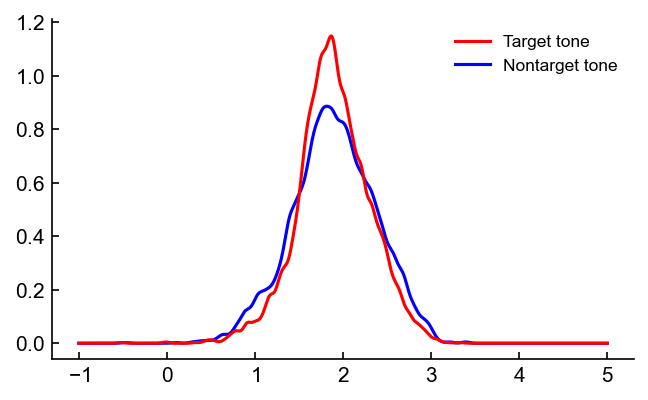

In [115]:
numclusts = 1
clustsToUse = sessionfile.clusters.good
clustsToUse = clustsToUse[0:min(numclusts,len(clustsToUse))]

for clust in tqdm(clustsToUse):
    best_bw = ilep.sklearn_grid_search_bw(sessionfile,clust)
    
    xmin = -1
    xmax = 5
    xrange = np.linspace(xmin,xmax,num=1000)
    
    
    folds = ilep.K_fold_strat(sessionfile,sessionfile.trim[clust].trimmed_trials,10)
    TargISILibraries = np.zeros((len(xrange),len(folds)))
    NontargISILibraries = np.zeros((len(xrange),len(folds)))
    for K, (Train_X, Test_X) in enumerate(folds):
        
        model = ilep.trainDecodingAlgorithm(sessionfile,clust,best_bw,Train_X,['target_tone','nontarget_tone'],control=False)
        
        TargISILibraries[:,K] = model['target_tone'].Likelihood.evaluate(xrange)
        NontargISILibraries[:,K] = model['nontarget_tone'].Likelihood.evaluate(xrange)

    TargISILibrariesSTD = np.std(TargISILibraries,axis=1)
    TargISILibrariesSEM = sem(TargISILibraries,axis=1)
    TargISILibrariesMEAN = np.mean(TargISILibraries,axis=1)
    NontargISILibrariesSTD = np.std(NontargISILibraries,axis=1)
    NontargISILibrariesSEM = sem(NontargISILibraries,axis=1)
    NontargISILibrariesMEAN = np.mean(NontargISILibraries,axis=1)

    fig,ax = plt.subplots(figsize=(5,3))
    
    ax.plot(xrange,TargISILibrariesMEAN,color='blue',zorder=10)
    ax.fill_between(xrange,TargISILibrariesMEAN+TargISILibrariesSEM,TargISILibrariesMEAN-TargISILibrariesSEM,color='blue',alpha=0.25,lw=0,zorder=9)
    
    ax.plot(xrange,NontargISILibrariesMEAN,color='red',zorder=10)
    ax.fill_between(xrange,NontargISILibrariesMEAN+NontargISILibrariesSEM,NontargISILibrariesMEAN-NontargISILibrariesSEM,color='red',alpha=0.25,lw=0,zorder=9)
    
    ax.plot([],[],color='red',label='Target tone')
    ax.plot([],[],color='blue',label='Nontarget tone')
    ax.legend(frameon=False)

    fig.savefig(os.path.join('D:\\Figures','Decoding Schematics','ISI Libraries',ilep.generateDateString(sessionfile)+' cluster '+str(clust)))

# Plot Weighted LLR

100%|██████████| 1/1 [00:07<00:00,  7.06s/it]


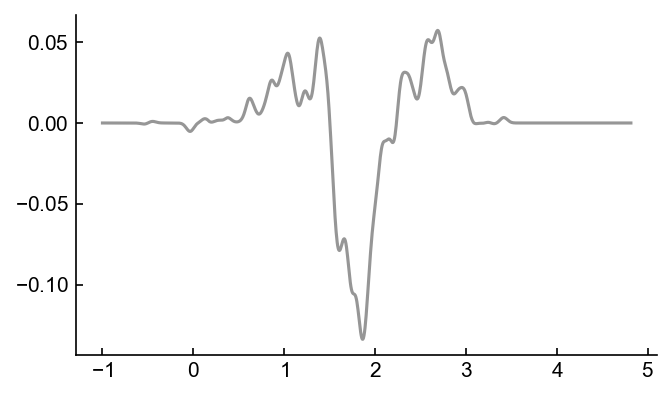

In [117]:
numclusts = 1
clustsToUse = sessionfile.clusters.good
clustsToUse = clustsToUse[0:min(numclusts,len(clustsToUse))]

for clust in tqdm(clustsToUse):
    best_bw = ilep.sklearn_grid_search_bw(sessionfile,clust)
    bw = best_bw

    condition_names = ['all_trials','target_tone','nontarget_tone']
    model = ilep.trainDecodingAlgorithm(sessionfile,clust,bw,Train_X,condition_names)

    xmin = -1
    xmax = 5
    xrange = np.linspace(xmin,xmax,num=1000)

    target = model['target_tone'].Likelihood.evaluate(xrange)
    nontarget = model['nontarget_tone'].Likelihood.evaluate(xrange)
    alltrials = model['all_trials'].Likelihood.evaluate(xrange)
    
    #result = (np.log10(target) - np.log10(nontarget)) / np.log10(alltrials)
    #print(np.sort(np.unique(target)))
    #ax.plot((target))

    result = (np.log10(target) - np.log10(nontarget)) * alltrials
    
    fig,ax = plt.subplots(figsize=(5,3))
    
    #Calculate which sections are above/below 0
    rs = np.row_stack((result,np.zeros(len(result))))
    posres = np.max(rs,axis=0)
    negres = np.min(rs,axis=0)
    
    #ax.fill_between(xrange,posres,color='red',lw=0,alpha=0.125,label='Target tone')
    #ax.fill_between(xrange,negres,color='blue',lw=0,alpha=0.125,label='Nontarget tone')
    
#     for idx in range(len(xrange)-1):
#         if result[idx] > 0:
#             color = 'red'
#         else:
#             color = 'blue'
#         ax.plot(xrange[idx:idx+2],result[idx:idx+2],color=color,alpha=1,lw=1.5)
    
    ax.plot(xrange,result,color=GOOD_GREY,alpha=1,lw=1.5)
    
    try:
        fig.savefig(os.path.join('D:\\Figures','Decoding Schematics','W LLRs',ilep.generateDateString(sessionfile)+' cluster '+str(clust)))
    except:
        fig.savefig(os.path.join('D:\\Figures','Decoding Schematics','W LLRs',ANIMAL+' cluster '+str(clust)))
    pass

In [7]:
# def CalculatePosterior(prior,posmodel,negmodel,logISI):
#     return prior + np.log10(posmodel.Likelihood.evaluate(logISI)) - np.log10(negmodel.Likelihood.evaluate(logISI))

In [8]:
plot=False

correct_trials = 0
incorrect_trials = 0

accumulated_correct_predictions = 0
accumulated_total_predictions = 0

for clust in sessionfile.clusters.good:
    folds = ilep.K_fold_strat(sessionfile,sessionfile.trim[clust].trimmed_trials,10)
    for K, (Train_X, Test_X) in enumerate(folds):
        best_bw = 0.2
        model = ilep.trainDecodingAlgorithm(sessionfile,clust,best_bw,Train_X,['target_tone','nontarget_tone'])
        for trial in Test_X:
            
            prediction,prob,probabilities,times = ilep.predictTrial(sessionfile,clust,model,trial,conditions = ['target_tone','nontarget_tone'])

            if(plot):
                fig,ax = plt.subplots(figsize=(5,3))
                gs = fig.add_gridspec(2,1,height_ratios=[1,5],hspace=0.01)
                ax = plt.subplot(gs[1,0])
                ax2 = plt.subplot(gs[0,0],sharex=ax)

                Tcond = 'target_tone'
                NTcond = 'nontarget_tone'
                
                ax.step(times,probabilities[Tcond].prob,color='red',label='target',where='post')
                ax.step(times,probabilities[NTcond].prob,color='blue',label='nontarget',where='post')
                ax.set_xticks([0,500,1000,1500,2000,2500])
                ax.set_xticklabels(['0','500','1000','1500','2000','2500'])
                ax.set_xlabel('Time (ms)')
                ax.set_ylabel('Accumulated LL')

                ax2.eventplot(times[1:len(times)],color='k')
                ax2.spines['bottom'].set_visible(False)
                ax2.spines['left'].set_visible(False)
                ax2.get_xaxis().set_visible(False)
                ax2.get_yaxis().set_visible(False)
                ax.legend(frameon=False)

                x_axes = ax.get_xlim()
                y_axes = ax.get_ylim()
                #Fill between
                ax.set_xlim(x_axes)
                ax.set_ylim(y_axes)
            else:
                pass
                #Calculate accuracy


    #Potential discrepancy: correct/incorrect needs to be weighted
    print('correct  : '+str(correct_trials))
    print('incorrect: '+str(incorrect_trials))

    print('PC: '+str(accumulated_correct_predictions/accumulated_total_predictions))

correct  : 0
incorrect: 0


ZeroDivisionError: division by zero

# Run Calculation on Rat Data

In [5]:
categories = 'stimulus'
reps = 1000

In [6]:
ANIMALS_LIST = [key for key in ANIMALS]

sessions = []
clusters = []
accuracies = []
accuracies_std = []
accuracies_sem = []
waccuracies = []
waccuracies_std = []
waccuracies_sem = []
caccuracies = []
caccuracies_std = []
caccuracies_sem = []
saccuracies = []
saccuracies_std = []
saccuracies_sem = []
pvals_c = []
pvals_s = []
frac_empty = []

EnumANIMAL = []
EnumClust = []
for ANIMAL in ANIMALS_LIST:
    try:
        sessionfile = load_session_h5py(ANIMAL)
        for clust in sessionfile.clusters.good:
            EnumANIMAL.append(ANIMAL)
            EnumClust.append(clust)
    except Exception as e:
        pass

for idx in tqdm(range(len(EnumClust))):
    ANIMALID = EnumANIMAL[idx]
    clust = EnumClust[idx]
    
    if ANIMAL != ANIMALID:
        ANIMAL = ANIMALID
        sessionfile = load_session_h5py(ANIMAL)
    
    try:
        a,astd,asem,wa,wastd,wasem,ca,castd,casem,sa,sastd,sasem,pval_c,pval_s,f_e = CalculateClusterAccuracy(sessionfile,clust,reps=reps,categories=categories)
        accuracies.append(a)
        accuracies_std.append(astd)
        accuracies_sem.append(asem)
            
        waccuracies.append(wa)
        waccuracies_std.append(wastd)
        waccuracies_sem.append(wasem)
            
        caccuracies.append(ca)
        caccuracies_std.append(castd)
        caccuracies_sem.append(casem)
        
        saccuracies.append(sa)
        saccuracies_std.append(sastd)
        saccuracies_sem.append(sasem)
        
        pvals_c.append(pval_c)
        pvals_s.append(pval_s)
        
        frac_empty.append(f_e)
        
        sessions.append(ANIMAL)
        clusters.append(clust)
        repetitions.append(reps)
    except Exception as e:
        #print('failure loading '+ANIMAL)
        #raise e
        pass
        
######################## SAVING TO DISK ######################################
        
data = np.column_stack([sessionIDs,clusters,accuracies,accuracies_std,accuracies_sem,waccuracies,waccuracies_std,waccuracies_sem,caccuracies,caccuracies_std,caccuracies_sem,pvals,repetitions])
labels = ['sessions','clusters','accuracies','accuracies_std','accuracies_sem','waccuracies','waccuracies_std','waccuracies_sem','caccuracies','caccuracies_std','caccuracies_sem','pvals','repetitions']
df = pd.DataFrame(data=data, columns=labels)
print(df)
df.to_csv('D:\\RatData'+categories+'DecodingCached '+str(datetime.now())+'.csv')

KeyboardInterrupt: 

In [3]:
categories = 'stimulus'
reps = 1000

In [ ]:
sessions = os.listdir()